#  Phase-resolved spectroscopy of low frequency quasi-periodic oscillations
## Motivation
X-ray radiation from black hole binary (BHB) systems regularly displays quasi-periodic oscil- lations (QPOs). In principle, a number of suggested physical mechanisms can reproduce their power spectral properties, thus more powerful diagnostics which preserve phase are required to discern between different models. In this paper, we first find for two Rossi X-ray Timing Explorer (RXTE) observations of the BHB GRS 1915+105 that the QPO has a well defined average waveform. That is, the phase difference and amplitude ratios between the first two harmonics vary tightly around a well defined mean. This enables us to reconstruct QPO wave- forms in each energy channel, in order to constrain QPO phase-resolved spectra. We fit these phase resolved spectra across 16 phases with a model including Comptonisation and reflection (Gaussian and smeared edge components) to find strong spectral pivoting and a modulation in the iron line equivalent width. The latter indicates the observed reflection fraction is chang- ing throughout the QPO cycle. This points to a geometric QPO origin, although we note that the data presented here do not entirely rule out an alternative interpretation of variable disc ionisation state. We also see tentative hints of modulations in the iron line centroid and width which, although not statistically significant, could result from a non-azimuthally symmetric QPO mechanism.

## Dataset and Fitting Model
We fit power spectrum of reference band from type-C QPO dataset with two Lorentzian functions in order to measure centroid and full width at half maximum- one at fundamental and other at second harmonic. Our fitting model also includes one power law and one constant function. We use the resulting parameter further in our analysis.

In [22]:
from stingray import Lightcurve, Powerspectrum, AveragedPowerspectrum, Crossspectrum, AveragedCrossspectrum
from stingray.spectroscopy import load_lc_fits, get_parameters, compute_rms, waveform, get_phase_lag
from stingray.utils import nearest_power_of_two, standard_error
from stingray.modeling.scripts import fit_powerspectrum, fit_crossspectrum
from astropy.modeling import models

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Loading dataset

In [2]:
ref, ci, meta = load_lc_fits('./toy_TypeC_lightcurve.fits', counts_type=False)
dt = meta['DT']
n_bins = meta['N_BINS']
n_seg = meta['N_SEG']
n_seconds = meta['NSECONDS']
n_chans = meta['DETCHANS']

# stacking counts in all segments into one array
ref_counts = np.hstack(ref)
ci_counts = np.hstack(ci)
print(ref_counts.shape, ci_counts.shape)

0.0078125
(409600,) (5, 409600)


### Light curve and averaged power spectrum of reference band
Here, we can see see strong contribution from first harmonic at ~4Hz and week contribution from second harmonic at ~8.5Hz

In [3]:
ref_times = np.arange(0, n_seconds*n_seg, dt)
ref_lc = Lightcurve(ref_times, ref_counts, dt=dt)
ref_aps = AveragedPowerspectrum(ref_lc, norm='leahy', segment_size=n_seconds) # TODO: set `norm` to `abs`

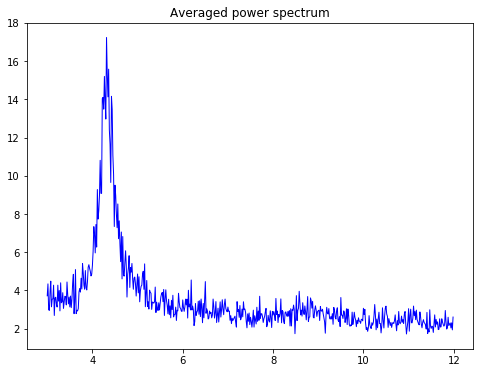

In [4]:
n = len(ref_aps.freq)
range_start, range_stop = int(3*n/64), int(12*n/64)

plt.figure(figsize=(8,6))
plt.title("Averaged power spectrum")
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(ref_aps.power)[range_start:range_stop], lw=1, color='blue')

### Fitting power spectrum with Astropy models

In [5]:
ref_aps_fitting_model = models.Lorentz1D(amplitude=12, x_0=4.3, fwhm=3.4) + models.Lorentz1D(x_0=9, amplitude=0.8, fwhm=2.) + models.PowerLaw1D(amplitude=0.1, x_0=1.5, alpha=0.8) + models.Const1D()

parest, res = fit_powerspectrum(ref_aps, ref_aps_fitting_model, fitmethod="CG")
ref_aps_result_model = res.model
print(ref_aps_result_model)
print(ref_aps_result_model.parameters)

Model: CompoundModel2
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2] + [3]
Components: 
    [0]: <Lorentz1D(amplitude=12., x_0=4.3, fwhm=3.4)>

    [1]: <Lorentz1D(amplitude=0.8, x_0=9., fwhm=2.)>

    [2]: <PowerLaw1D(amplitude=0.1, x_0=1.5, alpha=0.8)>

    [3]: <Const1D(amplitude=1.)>
Parameters:
       amplitude_0           x_0_0       ...      alpha_2          amplitude_3    
    ------------------ ----------------- ... ------------------ ------------------
    10.746898648190909 4.339529471145663 ... 0.5317988092527351 1.5500508733886027
[10.74689865  4.33952947  0.43673838  0.47847211  8.76563159  0.59341086
  2.10096417  2.11361963  0.53179881  1.55005087]


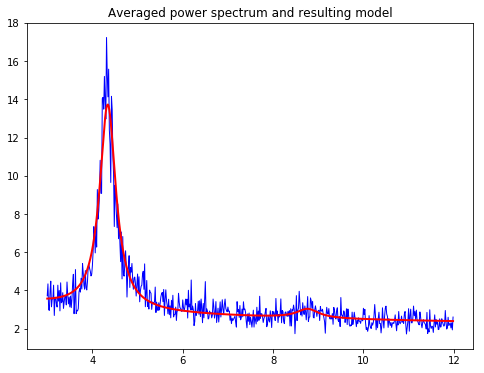

In [6]:
plt.figure(figsize=(8,6))
plt.title("Averaged power spectrum and resulting model")
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(ref_aps.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(ref_aps.freq[range_start:range_stop], np.abs(res.mfit)[range_start:range_stop], lw=2, color="red")

According to the paper, we split both light curves into **M** segments, with each segment containing **N** time bins of duration *dt*. We may expect the QPO to stay roughly coherent (i.e. periodic to a good approxi- mation) for *Q* cycles, where *Q* = ν<sub>0</sub>/FWHM is the quality factor (FWHM = 2 HWHM). We therefore choose N to ensure that each segment contains ∼ *Q* cycles of the fundamental, whilst also requiring N to be an integer power of two in order to use the Fast Fourier Transform algorithm. Thus, N ∼ 1/(FWHM *dt*).

In [7]:
fwhm = ref_aps_result_model[0].fwhm.value # FWHM of Lorentzian function fitted at the first harmonic

new_n_bins = nearest_power_of_two(1/(fwhm*dt))
new_n_seg = int(n_bins*n_seg/new_n_bins)

df_old = 1/(n_bins*dt)
df_new = fwhm
dt_new = 1/(new_n_bins*df_new)

print("old N:", n_bins)
print("new N:", new_n_bins)
print("old M:", n_seg)
print("new M:", new_n_seg)
print("old df:", df_old)
print("new df:", df_new)
print("new dt:", dt_new)

old N: 8192
new N: 512
old M: 50
new M: 800
old df: 0.015625
new df: 0.43673838008509636
new dt: 0.004472070898874156


Now, we re-bin the power spectrum and again fit the model. This resulting parameters will be used to reconstruct the QPO waveform.

In [8]:
ref_aps_rebinned = ref_aps.rebin(df=df_new)

ref_aps_rebinned_fitting_model = models.Lorentz1D(amplitude=12, x_0=4.3, fwhm=3.4) + models.Lorentz1D(x_0=9, amplitude=0.8, fwhm=2.) + models.PowerLaw1D(amplitude=0.1, x_0=1.5, alpha=0.8) + models.Const1D()

parest, res = fit_powerspectrum(ref_aps_rebinned, ref_aps_rebinned_fitting_model, fitmethod="CG")
ref_aps_rebinned_result_model = res.model

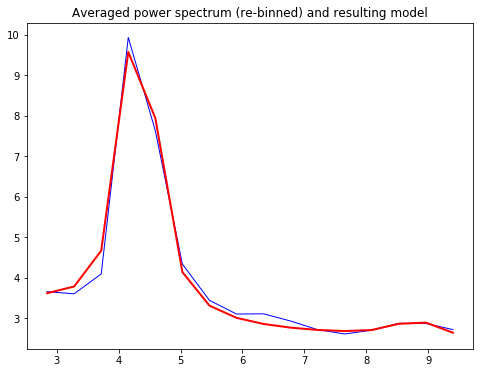

In [9]:
n = len(ref_aps_rebinned.freq)
range_start, range_stop = int(3*n/64), int(10*n/64)

plt.figure(figsize=(8,6))
plt.title("Averaged power spectrum (re-binned) and resulting model")
plt.plot(ref_aps_rebinned.freq[range_start:range_stop], np.abs(ref_aps_rebinned.power)[range_start:range_stop], lw=1, color='blue')
plt.plot(ref_aps_rebinned.freq[range_start:range_stop], np.abs(ref_aps_rebinned_result_model(ref_aps_rebinned.freq))[range_start:range_stop], lw=2, color="red")

## Reconstruction of the QPO waveform
The periodic function of QPO phase (*φ*) is given by
<img src="./equation_6.png" alt="Equation 6" style="width: 300px;"/>

where
- μ - mean count rate
- *J* - number of harmonics (in our case, *J* = 2)
- ⟨σ<sub>j</sub>⟩ - measured fractional rms in the j<sup>th</sup> harmonic
- Φ<sub>j</sub> - Phase offset of j<sup>th</sup> harmonic
Stingray provides the useful functions to compute all parameters.

In [10]:
avg_sigma_1 = compute_rms(ref_aps_rebinned, ref_aps_rebinned_result_model[0], criteria="posfreq") # 1st harmonic Lorentzian
avg_sigma_2 = compute_rms(ref_aps_rebinned, ref_aps_rebinned_result_model[1], criteria="posfreq") # 2nd harmonic Lorentzian

mu, cap_phi_1, cap_phi_2, small_psi = get_parameters(ref_counts, dt_new, ref_aps_rebinned_result_model)

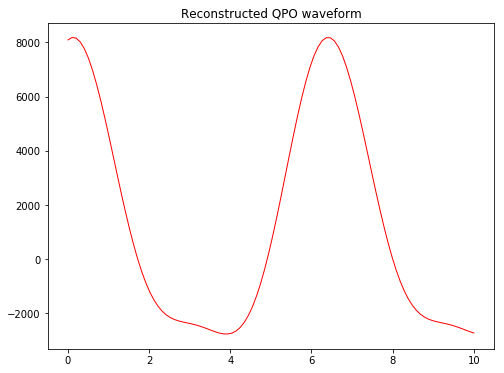

In [11]:
wave_x = np.linspace(0., 10., 100)
wave_y_avg = waveform(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

plt.figure(figsize=(8,6))
plt.title("Reconstructed QPO waveform")
plt.plot(wave_x, wave_y_avg, lw=1, color='red')

### Error calculation

In [12]:
ref_counts_seg = np.array_split(ref_counts, new_n_seg)

wave_ys = np.array([])

for i in range(new_n_seg): # for each segment
    # light curve and power spectrum
    ref_counts_seg_i = ref_counts_seg[i]
    ref_times_seg = np.arange(0, len(ref_counts_seg_i)*dt, dt)

    # plotting reference band lightcurve
    ref_lc_seg = Lightcurve(ref_times_seg, ref_counts_seg_i, dt=dt)
    ref_ps_seg = Powerspectrum(ref_lc_seg, norm='leahy')

    # calculation of parameters
    avg_sigma_1, avg_sigma_2
    mu, cap_phi_1, cap_phi_2, small_psi = get_parameters(ref_counts_seg_i, dt_new, ref_aps_rebinned_result_model) # reusing the previouslly fitted model
    
    # waveform
    wave_y = waveform(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

    if i == 0:
        wave_ys = np.hstack((wave_ys, np.array(wave_y)))
    else:
        wave_ys = np.vstack((wave_ys, np.array(wave_y)))

In [13]:
error = standard_error(wave_ys, wave_y_avg)
error

array([293.86373741, 294.7884988 , 292.22477034, 286.27549523,
       277.17467878, 265.28345553, 251.08515536, 235.17968805,
       218.27696215, 201.18721306, 184.80200408, 170.0526594 ,
       157.82601503, 148.82329468, 143.38629481, 141.37697375,
       142.20747474, 145.02207462, 148.92385691, 153.13980553,
       157.09473846, 160.41922136, 162.92505285, 164.57009393,
       165.42249737, 165.62781122, 165.37967639, 164.89399758,
       164.38638449, 164.05280777, 164.05358366, 164.50091713,
       165.45026931, 166.89576471, 168.76973452, 170.94634133,
       173.24909314, 175.46196606, 177.34382834, 178.64589186,
       179.13200277, 178.60172251, 176.91633525, 174.02810244,
       170.0130822 , 165.10711383, 159.74190733, 154.57134929,
       150.46505469, 148.43104884, 149.4346186 , 154.14029768,
       162.69907961, 174.71395885, 189.386797  , 205.72738457,
       222.71839355, 239.40873184, 254.9551728 , 268.63782883,
       279.86550744, 288.1781439 , 293.24859524, 294.88

## Phase resolving method
This method generalises the previous equation of QPO waveform for each energy channel:
<img src="./equation_7.png" alt="Equation 7" style="width: 400px;"/>

where
- μ(*E*) - mean count rate
- *J* - number of harmonics (in our case, *J* = 2)
- ⟨σ<sub>j</sub>(*E*)⟩ - measured fractional rms in the j<sup>th</sup> harmonic
- Φ<sub>j</sub>(*E*) - Phase offset of j<sup>th</sup> harmonic

We show the analysis for single channel of interest. You'll observe that the step to calculate mean count rate, and RMS is similar to the steps followed in the previous section.

In [14]:
ci_times = np.arange(0, n_seconds*n_seg, dt)
ci_counts_0 = ci_counts[0] # Choosing channel 1

# light curve and averaged power spectrum
ci_lc = Lightcurve(ci_times, ci_counts_0, dt=dt)
ci_aps = AveragedPowerspectrum(ci_lc, norm='leahy',segment_size=n_seconds) # TODO: set `norm` to `abs`

# fitting power spectrum with Astropy models
ci_aps_fitting_model = models.Lorentz1D(x_0=4.3) + models.Lorentz1D(x_0=9) + models.PowerLaw1D(x_0=1.5) + models.Const1D()

parest, res = fit_powerspectrum(ci_aps, ci_aps_fitting_model, fitmethod="CG")
ci_aps_result_model = res.model
print(ci_aps_result_model.parameters)

[1.20118035 4.30640685 0.22537506 0.35231031 9.14251108 0.12483837
 0.8736283  1.44974524 0.44376118 1.78722007]


In [15]:
fwhm = ci_aps_result_model[0].fwhm.value # FWHM of Lorentzian function fitted at the first harmonic

new_n_bins = nearest_power_of_two(1/(fwhm*dt))
new_n_seg = int(n_bins*n_seg/new_n_bins)

df_old = 1/(n_bins*dt)
df_new = fwhm
dt_new = 1/(new_n_bins*df_new)

print("old N:", n_bins)
print("new N:", new_n_bins)
print("old M:", n_seg)
print("new M:", new_n_seg)
print("old df:", df_old)
print("new df:", df_new)
print("new dt:", dt_new)

old N: 8192
new N: 1024
old M: 50
new M: 400
old df: 0.015625
new df: 0.22537505742268985
new dt: 0.004333054913740795


In [16]:
ci_aps_rebinned = ci_aps.rebin(df=df_new)

avg_sigma_1 = compute_rms(ci_aps_rebinned, ci_aps_fitting_model[0], criteria="posfreq") # 1st harmonic Lorentzian
avg_sigma_2 = compute_rms(ci_aps_rebinned, ci_aps_fitting_model[1], criteria="posfreq") # 2nd harmonic Lorentzian

mu = np.mean(ci_counts_0/dt_new)

### Phase lag computation

We calculate the lags in the usual way by taking the cross spectrum between each subject band, s(E,t), and the reference band r(t), which we define as the full band with the subject. The required phase offsets are given by:
<img src="./equation_8.png" alt="Equation 8" style="width: 300px;"/>
Stingray provides a function to compute phase offsets and phase difference.

In [17]:
ci_acs = AveragedCrossspectrum(lc2=ci_lc, lc1=ref_lc, segment_size=n_seconds, norm='leahy', power_type="real") # TODO: add ampltiude = True param

In [18]:
cap_phi_1, cap_phi_2, _ = get_phase_lag(ci_acs, ci_aps_fitting_model)

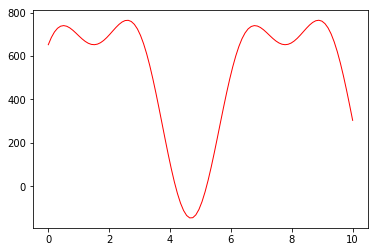

In [19]:
wave_x = np.linspace(0., 10., 100)
wave_y_avg = waveform(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

plt.figure()
plt.plot(wave_x, wave_y_avg, lw=1, color='red')

### Error Calculation

In [20]:
ci_counts_seg = np.array_split(ci_counts_0, new_n_seg)
ref_counts_seg = np.array_split(ref_counts, new_n_seg)

wave_ys = np.array([])

for i in range(new_n_seg): # for each segment
    # light curve and power spectrum
    ref_counts_seg_i = ref_counts_seg[i]
    ci_counts_seg_i = ci_counts_seg[i]
    ref_times_seg = np.arange(0, len(ref_counts_seg_i)*dt, dt)
    ci_times_seg = np.arange(0, len(ci_counts_seg_i)*dt, dt)
    
    ref_lc_seg = Lightcurve(ref_times_seg, ref_counts_seg_i, dt=dt)
    ref_ps_seg = Powerspectrum(ref_lc_seg, norm='leahy')
    
    # df_new is not calculated again by fitting model because diffulty in fitting - plausible reason is noisy signal
    ci_lc_seg = Lightcurve(ci_times_seg, ci_counts_seg_i, dt=dt)
    ci_ps_seg = Powerspectrum(ci_lc_seg, norm='leahy')
    ci_ps_seg_new = ci_ps_seg.rebin(df=df_new) # reusing df_new

    # calculation of parameters - here `ps_res_model` is fitted model on CoI averaged power spectrum
    avg_sigma_1 = compute_rms(ci_ps_seg_new, ci_aps_fitting_model[0], criteria="posfreq") # 1st harmonic Lorentzian
    avg_sigma_2 = compute_rms(ci_ps_seg_new, ci_aps_fitting_model[1], criteria="posfreq") # 2nd harmonic Lorentzian

    x = ci_counts_seg_i/dt_new
    mu = np.mean(x)

    ci_acs_seg = Crossspectrum(lc2=ci_lc_seg, lc1=ref_lc_seg, norm='leahy', power_type="all") # add ampltiude = True param
  
    cap_phi_1, cap_phi_2, _ = get_phase_lag(ci_acs_seg, ref_aps_result_model)

    # waveform
    wave_x = np.linspace(0., 10., 100)
    wave_y = waveform(wave_x, mu, avg_sigma_1, avg_sigma_2, cap_phi_1, cap_phi_2)

    if i == 0:
        wave_ys = np.hstack((wave_ys, np.array(wave_y)))
    else:
        wave_ys = np.vstack((wave_ys, np.array(wave_y)))

In [21]:
error = standard_error(wave_ys, wave_y_avg)
error

array([17.18758902, 17.67354317, 17.95899663, 18.02719978, 17.88760707,
       17.57056783, 17.1218422 , 16.59654329, 16.0522472 , 15.54146998,
       15.10448633, 14.76426605, 14.52544247, 14.37813779, 14.30553658,
       14.29257949, 14.33293134, 14.43220738, 14.60657124, 14.87693784,
       15.26025576, 15.76056378, 16.36292699, 17.03225949, 17.7169321 ,
       18.35539862, 18.88375448, 19.24283807, 19.38437488, 19.27627269,
       18.90746602, 18.29280964, 17.47846831, 16.54779077, 15.62597052,
       14.87750508, 14.48421848, 14.59401823, 15.25888595, 16.41164466,
       17.90178264, 19.55210663, 21.19711451, 22.69819051, 23.9463605 ,
       24.8610496 , 25.38838822, 25.49999042, 25.19222952, 24.48586846,
       23.42596099, 22.08201245, 20.54832589, 18.94399219, 17.41060656,
       16.10305122, 15.16615172, 14.69492148, 14.69559624, 15.0799728 ,
       15.70209522, 16.40782217, 17.06784291, 17.58981061, 17.91837837,
       18.03080754, 17.93165018, 17.64743589, 17.22125497, 16.70